In [2]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error

from hyperopt import fmin, tpe, hp, SparkTrials, Trials, STATUS_OK
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import mlflow

import pandas as pd
import numpy as np
import warnings
import sys
import pickle

In [3]:
# suppressing warning messages

warnings.filterwarnings('ignore')

In [4]:
# importing scripts

sys.path.insert(1, '../scripts')

from data_viz import Data_Viz
from data_cleaning import DataCleaner
from data_transformation import DataTransformer

DV = Data_Viz("../logs/data_model_notebook.log")
DC = DataCleaner("../logs/data_model_notebook.log")
DT = DataTransformer("../logs/data_model_notebook.log")

In [5]:
# importing the data

train = pd.read_csv("../data/train_store.csv")

In [6]:
# selecting out some features

train_cl = train.drop(["Customers"], axis=1) # we are taking customers feature out 
sales = train_cl.pop("Sales")
train_cl.insert(0,"Sales", sales)            # moving the target in the first position
DV.summ_columns(train_cl)


,variables,missing_count,missing_percent_(%),data_type,unique_values
0,Sales,0,0.0,float64,13194
1,Store,0,0.0,int64,1115
2,DayOfWeek,0,0.0,int64,7
3,Date,0,0.0,object,942
4,Open,0,0.0,int64,2
5,Promo,0,0.0,int64,2
6,StateHoliday,0,0.0,object,4
7,SchoolHoliday,0,0.0,int64,2
8,StoreType,0,0.0,object,4
9,Assortment,0,0.0,object,3


In [7]:
# separating numerical and categorical variables

categorical_lis, numerical_lis = DT.sep_cat_num(train_cl)
categorical_lis.head()

,Date,StateHoliday,StoreType,Assortment,PromoInterval
0,2015-07-31,No Holiday,c,a,Not_Av
1,2015-07-31,No Holiday,a,a,"Jan,Apr,Jul,Oct"
2,2015-07-31,No Holiday,a,a,"Jan,Apr,Jul,Oct"
3,2015-07-31,No Holiday,c,c,Not_Av
4,2015-07-31,No Holiday,a,a,Not_Av


In [8]:
# setup pipeline

sampled_train_cl = train_cl.sample(n=80000)  # taking a smaller sample of the data to minimize testing time
sets, scaler = DT.build_pipe(categorical_lis.columns.to_list()).fit_transform(sampled_train_cl)

              Date StateHoliday StoreType Assortment     PromoInterval
33513   2015-07-01   No Holiday         d          c   Jan,Apr,Jul,Oct
695604  2013-10-16   No Holiday         a          a            Not_Av
57627   2015-06-10   No Holiday         d          c            Not_Av
76801   2015-05-24   No Holiday         d          a            Not_Av
738216  2013-09-08   No Holiday         a          c  Mar,Jun,Sept,Dec
catagories successfully labeled
        Date  StateHoliday  StoreType  Assortment  PromoInterval
33513    911             2          3           2              1
695604   288             2          0           0              3
57627    890             2          3           2              3
76801    873             2          3           0              3
738216   250             2          0           2              2
Data successfully scaled
target and features separated
data successfully splitted


In [9]:
# Enable autolog()
mlflow.set_experiment("Random forest modeling experiment")
mlflow.sklearn.autolog()

In [10]:

# With autolog() enabled, all model parameters, a model score, and the fitted model are automatically logged.  
with mlflow.start_run():
  
  # Set the model parameters. 
  n_estimators = 100
  max_depth = 1
  
  # Create and train model.
  rf = RandomForestRegressor(n_estimators = n_estimators, max_depth = max_depth)
  rf.fit(sets[0], sets[1])
  
  # Use the model to make predictions on the test dataset.
  predictions = rf.predict(sets[2]) 

In [11]:
error = mean_squared_error(predictions, sets[3])
accuracy = rf.score(sets[2], sets[3])
print("accuracy: ", accuracy, " Error: ", error)

accuracy:  0.5535630325063228  Error:  0.024890959810240157


In [12]:
# fitting data using Random Forest Regressor
with mlflow.start_run():
    model = RandomForestRegressor(random_state=0)
    param_vals = {'max_depth': [5, 10, 15, 20], 'n_estimators': [40, 60, 80]}

    random_rf = GridSearchCV(estimator=model, param_grid=param_vals,
    cv = 6, refit=True, n_jobs=-1, return_train_score=True)
    
    # fit the regressor with x and y data
    random_rf.fit(sets[0], sets[1]) 
    random_rf.best_estimator_.score(sets[2], sets[3])
    mean_squared_error(predictions, sets[3])


2022/05/28 15:17:05 INFO mlflow.sklearn.utils: Logging the 5 best runs, 7 runs will be omitted.


In [13]:
# results
out = random_rf.cv_results_
pair = {"parameters":out['params'], "score":out['mean_test_score'],  }
pair = pd.DataFrame(pair)
pair

,parameters,score
0,"{'max_depth': 5, 'n_estimators': 40}",0.653287
1,"{'max_depth': 5, 'n_estimators': 60}",0.653376
2,"{'max_depth': 5, 'n_estimators': 80}",0.653446
3,"{'max_depth': 10, 'n_estimators': 40}",0.717334
4,"{'max_depth': 10, 'n_estimators': 60}",0.717835
5,"{'max_depth': 10, 'n_estimators': 80}",0.718086
6,"{'max_depth': 15, 'n_estimators': 40}",0.795832
7,"{'max_depth': 15, 'n_estimators': 60}",0.796598
8,"{'max_depth': 15, 'n_estimators': 80}",0.797071
9,"{'max_depth': 20, 'n_estimators': 40}",0.843444


In [14]:
predictions = random_rf.best_estimator_.predict(sets[2])
error = mean_squared_error(predictions, sets[3])
accuracy = random_rf.best_estimator_.score(sets[2], sets[3])
print("accuracy: ", accuracy, " Error: ", error)

accuracy:  0.8540584750706002  Error:  0.008136926142242689


**Observation**
- Desired level of accuracy has been reached = 0.85
- Model will be trained based on the above hyperparameters.

### Loss functions

- MAE = Mean Absolute Eror. this is robhust when outliers are present in the data. 
- MSE = Mean Squared Eror. This function penalizes large errors and it is easiy to calculate gradients.

Since there are no outliers in the data, MSE is chosen.



### calculating feature importance

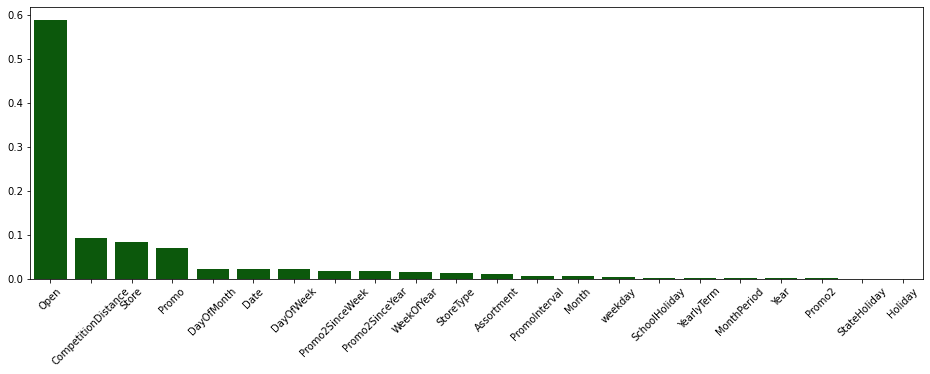

In [15]:
#features, target= DT.target_feature(train_cl, 0)

imp_dict = DV.get_importance(random_rf.best_estimator_, train_cl)
features = list(imp_dict.keys())
importance = list(imp_dict.values())
plt.figure(figsize=(16,5))
pal = sns.color_palette("flare", as_cmap=True)
ax = sns.barplot(features, importance, color="darkgreen")
ax.invert_xaxis()
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.show()

## reducing number of features

In [16]:
## Removing irrelevant features and cusomer
include_list = ["Sales", 'Month','Assortment', 'StoreType','WeekOfYear', 'DayOfWeek', 'DayOfMonth', 'Promo', 'Store', 'CompetitionDistance', 'Open', 'Holiday']
train_2 = train_cl[include_list]
train_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 12 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   Sales                1017209 non-null  float64
 1   Month                1017209 non-null  int64  
 2   Assortment           1017209 non-null  object 
 3   StoreType            1017209 non-null  object 
 4   WeekOfYear           1017209 non-null  int64  
 5   DayOfWeek            1017209 non-null  int64  
 6   DayOfMonth           1017209 non-null  int64  
 7   Promo                1017209 non-null  int64  
 8   Store                1017209 non-null  int64  
 9   CompetitionDistance  1017209 non-null  float64
 10  Open                 1017209 non-null  int64  
 11  Holiday              1017209 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 93.1+ MB


In [17]:
# separating numerical and categorical variables

categorical_lis2, numerical_lis2 = DT.sep_cat_num(train_2)

sampled_train_cl2 = train_2.sample(n=60000)
sets2, scaler = DT.build_pipe(categorical_lis2.columns.to_list()).fit_transform(sampled_train_cl2)

# fitting data using Random Forest Regressor
model2 = RandomForestRegressor(n_estimators = 40, max_depth = 16, random_state = 0)
 
# fit the regressor with x and y data
model2.fit(sets2[0], sets2[1])

# checking accuracy
accuracy2 = model2.score(sets2[2], sets2[3])
print("prediction accuracy: ", accuracy2)


2022/05/28 15:17:16 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '71c2fb6dc2a2451eb9fc76ec83e2aeff', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2022/05/28 15:17:16 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('labeling', FunctionTransformer(func=<bound method DataTransformer.cat_labeler of <data_transformation.DataTransformer object at 0x000001A9C99CE670>>,
                    kw_args={'cat_cols': ['Assortment', 'StoreType']})), ('scaling', FunctionT...`


       Assortment StoreType
625956          a         a
882435          c         c
901334          a         b
776407          a         d
241807          c         a
catagories successfully labeled
        Assortment  StoreType
625956           0          0
882435           2          2
901334           0          1
776407           0          3
241807           2          0


2022/05/28 15:17:16 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2022/05/28 15:17:16 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature


Data successfully scaled
target and features separated
data successfully splitted


2022/05/28 15:17:33 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '250124dcb3d848489cc8b8b899fc156b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


prediction accuracy:  0.7597092625358368


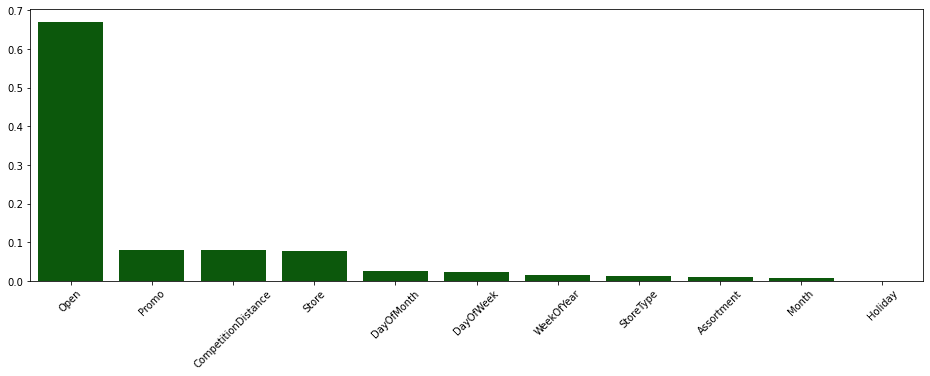

In [18]:
#features, target= DT.target_feature(train_cl, 0)
imp_dict = DV.get_importance(model2, train_2)
features = list(imp_dict.keys())
importance = list(imp_dict.values())
plt.figure(figsize=(16,5))
pal = sns.color_palette("flare", as_cmap=True)
ax = sns.barplot(features, importance, color="darkgreen")
ax.invert_xaxis()
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.show()

In [19]:
# datetime object containing current date and time
now = datetime.now()
time = now.strftime("%d-%m-%Y-%H-%M-%S")
filename = "../models/RFR-sales-"+str(time)+'.pkl'
pickle.dump(model2, open(filename, 'wb'))
# save the scaler
pickle.dump(scaler, open('../models/scaler-'+time+'.pkl', 'wb'))

## Predicting number of customers

In [20]:
## Removing irrelevant features and cusomer
include_list2 = ["Customers", 'Month', 'PromoInterval', 'Assortment', 'StoreType','WeekOfYear', 'DayOfWeek', 'DayOfMonth', 'Promo', 'Store', 'CompetitionDistance', 'Open']
train_3 = train[include_list2]

In [21]:
# separating numerical and categorical variables

categorical_lis3, numerical_lis3 = DT.sep_cat_num(train_3)

sampled_train_cl3 = train_3.sample(n=100000)
sets3, scaler = DT.build_pipe(categorical_lis3.columns.to_list()).fit_transform(sampled_train_cl3)

# fitting data using Random Forest Regressor
model3 = RandomForestRegressor(n_estimators = 100, random_state = 0)
 
# fit the regressor with x and y data
model3.fit(sets3[0], sets3[1])

# checking accuracy
accuracy3 = model3.score(sets3[2], sets3[3])
print("prediction accuracy: ", accuracy3)

2022/05/28 15:18:03 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '9c07bc1c604a43b4a94104db38e647fa', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2022/05/28 15:18:03 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('labeling', FunctionTransformer(func=<bound method DataTransformer.cat_labeler of <data_transformation.DataTransformer object at 0x000001A9C99CE670>>,
                    kw_args={'cat_cols': ['PromoInterval', 'Assortment',
                     ...`
2022/05/28 15:18:03 WARNING mlflow.utils: Truncated the value of the key `labeling`. Truncated value: `FunctionTransformer(func=<bound method DataTransformer.cat_labeler of <data_transformation.DataTransformer object at 0x000001A9C99CE670>>,
                    kw_args={'cat_cols': ['PromoInterval', 'Assortment',
                                   ...`


          PromoInterval Assortment StoreType
563849           Not_Av          a         a
832969  Jan,Apr,Jul,Oct          a         d
980164           Not_Av          c         d
334040  Jan,Apr,Jul,Oct          a         a
11318   Feb,May,Aug,Nov          a         d
catagories successfully labeled
        PromoInterval  Assortment  StoreType
563849              3           0          0
832969              1           0          3
980164              3           2          3
334040              1           0          0
11318               0           0          3


2022/05/28 15:18:05 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2022/05/28 15:18:05 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature


Data successfully scaled
target and features separated
data successfully splitted


2022/05/28 15:18:50 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'a46d0ddaaad14514b1f4e0ea62298a40', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


prediction accuracy:  0.9027734201373832


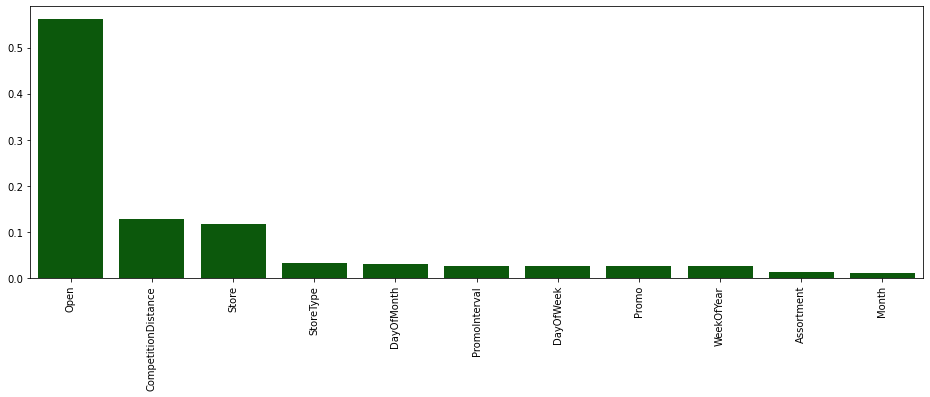

In [22]:
#features, target= DT.target_feature(train_cl, 0)
imp_dict = DV.get_importance(model3, train_3)
features = list(imp_dict.keys())
importance = list(imp_dict.values())
plt.figure(figsize=(16,5))
pal = sns.color_palette("flare", as_cmap=True)
ax = sns.barplot(features, importance, color="darkgreen",)
ax.invert_xaxis()
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.show()

In [23]:
# datetime object containing current date and time
now = datetime.now()
time = now.strftime("%d-%m-%Y-%H-%M-%S")
filename = "../models/RFR-customers-"+str(time)+'.pkl'
pickle.dump(model2, open(filename, 'wb'))
# save the scaler
pickle.dump(scaler, open('../models/scaler-'+time+'.pkl', 'wb'))